# Fingerprint-based activity prediction demo for Influenza B inhibitors

## Imports

In [1]:
import itertools
from multiprocessing.pool import ThreadPool

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit.Chem import rdMolDescriptors

import seaborn as sns;
sns.set_theme()

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.manifold import MDS, TSNE
from sklearn.model_selection import train_test_split

## Dataset

* ChEMBL target report: https://www.ebi.ac.uk/chembl/target_report_card/CHEMBL613129/
* EC50 activities: https://www.ebi.ac.uk/chembl/g/#browse/activities/filter/target_chembl_id%3ACHEMBL613129%20AND%20standard_type%3A(%22EC50%22)
* IC50 activities: https://www.ebi.ac.uk/chembl/g/#browse/activities/filter/target_chembl_id%3ACHEMBL613129%20AND%20standard_type%3A(%22IC50%22)

### Load and preview data

In [2]:
ec50_df = pd.read_csv('Influenza_B_EC50.csv')
ic50_df = pd.read_csv('Influenza_B_IC50.csv')

activity_df = pd.concat([ec50_df, ic50_df])
print(f'Number of measurements: {activity_df.shape[0]}')

Number of measurements: 905


In [3]:
activity_df[:5]

,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,...,Target Name,Target Organism,Target Type,Document ChEMBL ID,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID,Properties
0,CHEMBL4160248,NaN,0,389.46,0,0.61,19,COCCN1C(N)=NC(N)=NC12CCN(C(=O)Nc1ccc(OC)cc1)CC2,EC50,'>',...,Influenza B virus,Influenza B virus,ORGANISM,CHEMBL4152296,1,Scientific Literature,Eur J Med Chem,2018,None,NaN
1,CHEMBL4295108,NaN,0,1710.64,None,None,2a,CCCCCCCCCCCCCCCCOCc1cn([C@H]2C(=O)N[C@@H]3Cc4c...,EC50,'=',...,Influenza B virus,Influenza B virus,ORGANISM,CHEMBL4270630,1,Scientific Literature,Eur J Med Chem,2018,None,NaN
2,CHEMBL469986,NaN,0,478.37,0,2.99,20,Cc1cc(C)cc(S(=O)(=O)c2c(C(=O)NCCC(N)=O)[nH]c3c...,EC50,'>',...,Influenza B virus,Influenza B virus,ORGANISM,CHEMBL1153955,1,Scientific Literature,J. Med. Chem.,2009,CHEMBL3308370,NaN
3,CHEMBL2206458,TAMIPHOSPHOR MONOETHYL ESTER,0,348.38,0,1.90,"3c, TP1Et",CCOP(=O)(O)C1=C[C@@H](OC(CC)CC)[C@H](NC(C)=O)[...,EC50,'=',...,Influenza B virus,Influenza B virus,ORGANISM,CHEMBL2203066,1,Scientific Literature,J. Med. Chem.,2012,CHEMBL3308370,NaN
4,CHEMBL2420188,NaN,0,232.08,0,1.07,14a,CCCc1nc(N)[nH]c(=O)c1Br,EC50,'>',...,Influenza B virus,Influenza B virus,ORGANISM,CHEMBL2417481,1,Scientific Literature,Eur. J. Med. Chem.,2013,CHEMBL3308370,NaN


### Clean up data

Remove less/greater measurements

In [4]:
activity_df = activity_df[activity_df['Standard Relation'] == "'='"]
print(f'{activity_df.shape[0]} activities left with exact measurements')

414 activities left with exact measurements


Subset/rename columns

In [5]:
column_names_dict = {
    'Molecule ChEMBL ID': 'molecule_id',
    'Molecule Name': 'name',
    'pChEMBL Value': 'p_ic50',
    'Smiles': 'smiles'
}
columns_to_keep = list(column_names_dict.keys())
activity_df = pd.DataFrame(activity_df, columns=columns_to_keep).rename(columns=column_names_dict)


Remove null measurements

In [6]:
activity_df = activity_df.dropna(axis=0, subset=['molecule_id', 'p_ic50', 'smiles'])
activity_df.reset_index(drop=True, inplace=True)
print(f'{activity_df.shape[0]} activities left with non-null measurements')
activity_df[:5]

281 activities left with non-null measurements


,molecule_id,name,p_ic50,smiles
0,CHEMBL4295108,NaN,5.89,CCCCCCCCCCCCCCCCOCc1cn([C@H]2C(=O)N[C@@H]3Cc4c...
1,CHEMBL2206458,TAMIPHOSPHOR MONOETHYL ESTER,6.16,CCOP(=O)(O)C1=C[C@@H](OC(CC)CC)[C@H](NC(C)=O)[...
2,CHEMBL261459,NaN,4.62,NC(=O)c1nccn([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O...
3,CHEMBL3120588,NaN,4.40,CC(=O)OC[C@H]1O[C@@H](n2c(-c3cccs3)cc(-c3ccc(C...
4,CHEMBL4170117,NaN,6.26,CCCCCCCCCC(=O)Oc1ccc(COP(=O)(OCc2ccc(OC(=O)CCC...


### Transform smiles to molecules

,molecule_id,name,p_ic50,smiles,molecule
0,CHEMBL4295108,NaN,5.89,CCCCCCCCCCCCCCCCOCc1cn([C@H]2C(=O)N[C@@H]3Cc4c...,
1,CHEMBL2206458,TAMIPHOSPHOR MONOETHYL ESTER,6.16,CCOP(=O)(O)C1=C[C@@H](OC(CC)CC)[C@H](NC(C)=O)[...,
2,CHEMBL261459,NaN,4.62,NC(=O)c1nccn([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O...,

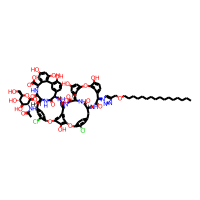
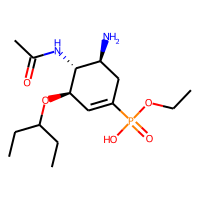
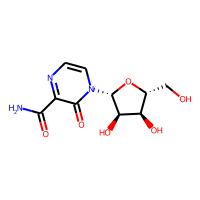

In [7]:
PandasTools.AddMoleculeColumnToFrame(activity_df,'smiles','molecule',includeFingerprints=True)
activity_df[:3]

## Molecular fingerprints exploration

### Show fingerprints for one molecule

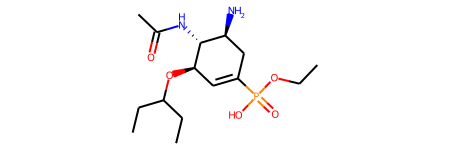

In [8]:
mol = activity_df.loc[1, 'molecule']
mol

Generate fingerprints

In [9]:
bits_info = {}
fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=2, bitInfo=bits_info)

num_bits_set = len(fp.GetOnBits())
print(f'{num_bits_set} bits set')

num_bits_to_show = 10
print(f'{num_bits_to_show} of set bits')
list(fp.GetOnBits())[:num_bits_to_show]

47 bits set
10 of set bits


[1, 80, 125, 192, 231, 235, 245, 294, 339, 387]

Show fingerprints graphically

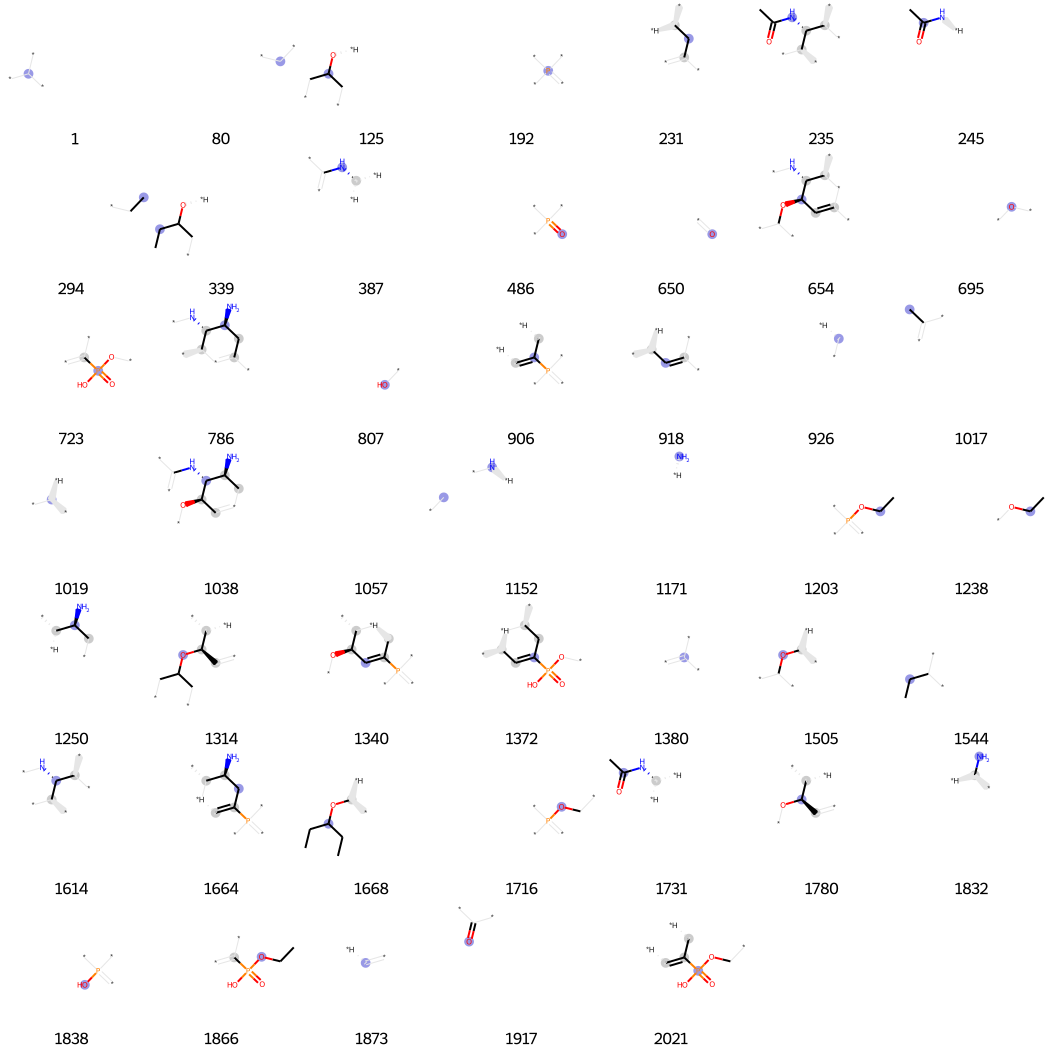

In [10]:
# Adapted from http://rdkit.blogspot.com/2018/10/using-new-fingerprint-bit-rendering-code.html
fp_tuples = [(mol, bit_idx, bits_info) for bit_idx in fp.GetOnBits()]
legends = [str(x) for x in fp.GetOnBits()]
Draw.DrawMorganBits(
    fp_tuples,
    molsPerRow=7,
    legends=legends
)

### Create fingerprint matrix

Fingerprint matrix shape: (281, 2000)
Non-zero elements: 17243, 3.07%


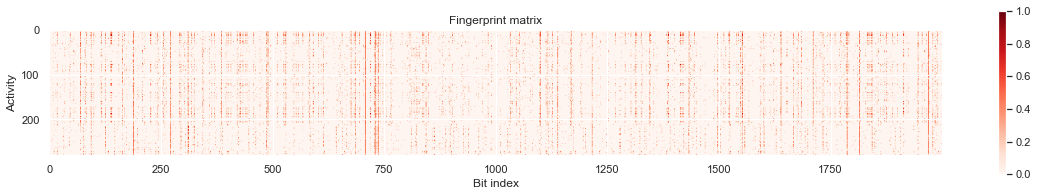

In [11]:
def generate_fp_matrix(molecule_series: pd.Series, fp_depth: int, fp_n_bits: int) -> np.ndarray:
    num_molecules = molecule_series.shape[0]
    fp_matrix = np.zeros((num_molecules, fp_n_bits))
    for mol_idx in range(num_molecules):
        mol = molecule_series[mol_idx]
        fp_bit_vect = AllChem.GetMorganFingerprintAsBitVect(mol, fp_depth, nBits=fp_n_bits)
        fp_np_vect = np.zeros((0,), dtype=np.int8)
        DataStructs.ConvertToNumpyArray(fp_bit_vect, fp_np_vect)
        fp_matrix[mol_idx, :] = fp_np_vect
        
    return fp_matrix  

fp_depth = 2
fp_n_bits = 2000

fp_matrix = generate_fp_matrix(activity_df['molecule'], fp_depth, fp_n_bits)


print(f'Fingerprint matrix shape: {fp_matrix.shape}')
non_zero_count = int(fp_matrix[fp_matrix > 0].sum())
total_elements = fp_matrix.shape[0] * fp_matrix.shape[1]
non_zero_percentage = 100.0 * non_zero_count / total_elements
print(f'Non-zero elements: {non_zero_count}, {non_zero_percentage:.2f}%')

fig = plt.figure(figsize=(20, 3))
plt.title('Fingerprint matrix')
plt.xlabel('Bit index')
plt.ylabel('Activity')
plt.imshow(fp_matrix, cmap=plt.get_cmap('Reds'))
plt.colorbar()
plt.show()

Extract activity vector

In [12]:
p_ic50_vec = np.array(activity_df['p_ic50'])

### Visual exploration

#### PCA

In [13]:
pca_transform = PCA()
Z_pca = pca_transform.fit_transform(fp_matrix)
explained_variance_1 = pca_transform.explained_variance_ratio_[0]
print(f'Explained variance for 1st PC: {100 * explained_variance_1}%')

exp_var_cumsum = np.cumsum(pca_transform.explained_variance_ratio_)
n_components_90 = len(exp_var_cumsum[exp_var_cumsum <= 0.90]) + 1
print(f'{n_components_90} PCs explain 90% variance')

Explained variance for 1st PC: 29.399586539298088%
36 PCs explain 90% variance


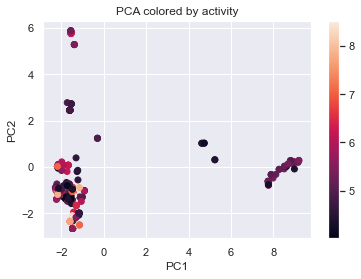

In [14]:
plt.scatter(Z_pca[:, 0], Z_pca[:, 1], c=p_ic50_vec)
plt.colorbar()
plt.title('PCA colored by activity')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

#### t-SNE

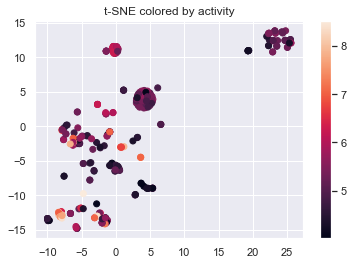

In [15]:
X_50pc = Z_pca[:, :50]
Z_tsne = TSNE(n_components=2, perplexity=40, random_state=42).fit_transform(X_50pc)
plt.scatter(Z_tsne[:, 0], Z_tsne[:, 1], c=p_ic50_vec)
plt.title('t-SNE colored by activity')
plt.colorbar()
plt.show()

## Activity models

Split data into train and test sets

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    fp_matrix, p_ic50_vec, test_size=0.25, random_state=42
)
print(f'{y_train.shape[0]} points in training set')
print(f'{y_test.shape[0]} points in test set')

210 points in training set
71 points in test set


In [17]:
def evaluate_model(X_train, X_test, model):
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)

    print(f'Training score: {train_score}')
    print(f'Test score: {test_score}')
    
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))
    y_train_predict = model.predict(X_train)
    y_test_predict = model.predict(X_test)

    for ax in (ax0, ax1):
        ax.set_xlabel('Measurements')
        ax.set_ylabel('Prediction')
        
    ax0.set_title(f'Training set, R2={train_score:.2f}')
    sns.regplot(x=y_train, y=y_train_predict, ax=ax0)

    ax1.set_title(f'Test set, R2={test_score:.2f}')
    sns.regplot(x=y_test, y=y_test_predict, ax=ax1)
    
    plt.show()


### Linear regression on top 50 PCs

Training score: 0.689644896691145
Test score: 0.20412886074148717


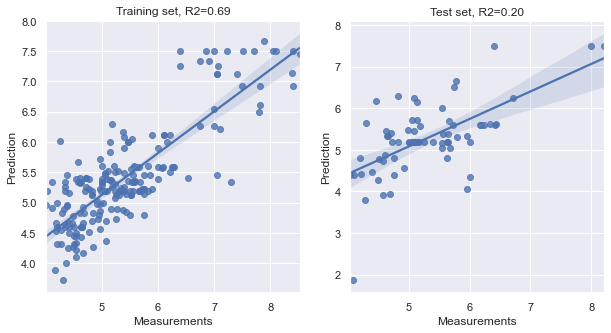

In [18]:
num_pcs = 50
X_50pcs_train = pca_transform.transform(X_train)[:, :num_pcs]
X_50pcs_test = pca_transform.transform(X_test)[:, :num_pcs]

linear_reg_50 = LinearRegression().fit(X_50pcs_train, y_train)
evaluate_model(X_50pcs_train, X_50pcs_test, linear_reg_50)

### Linear regression on raw fingerprints

Training score: 0.8983027490632323
Test score: -1.4148049657072995e+22


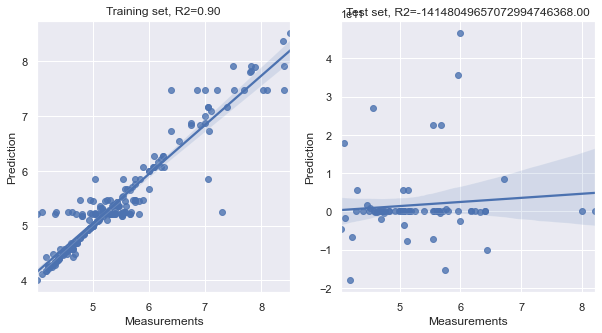

In [19]:
linear_reg_all = LinearRegression().fit(X_train, y_train)
evaluate_model(X_train, X_test, linear_reg_all)

### Random Forest on top 50 PCs

Training score: 0.8511453374911546
Test score: 0.44691388688816136


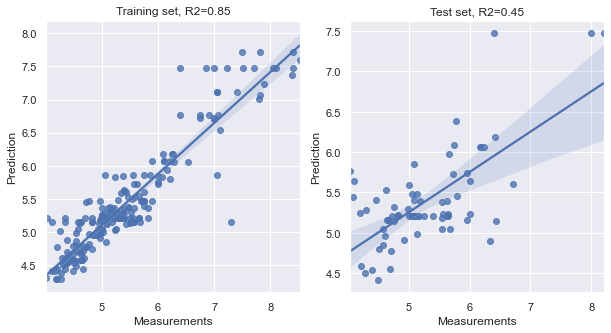

In [20]:
rf_reg_50 = RandomForestRegressor(random_state=0).fit(X_50pcs_train, y_train)
evaluate_model(X_50pcs_train, X_50pcs_test, rf_reg_50)

### Random Forest on all fingerprints

Training score: 0.858019960014202
Test score: 0.6193692473279997


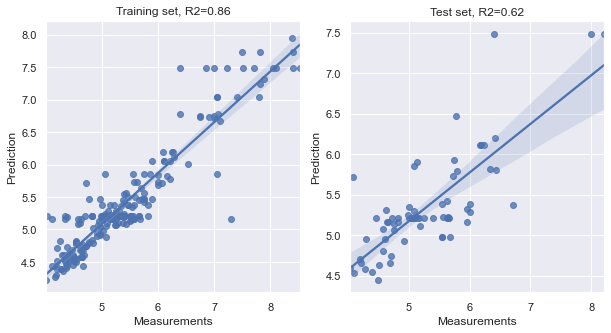

In [21]:
rf_reg_all = RandomForestRegressor(random_state=0).fit(X_train, y_train)
evaluate_model(X_train, X_test, rf_reg_all)

### Gradient Boosting on all fingerprints

Training score: 0.8542510143357651
Test score: 0.5859187725199703


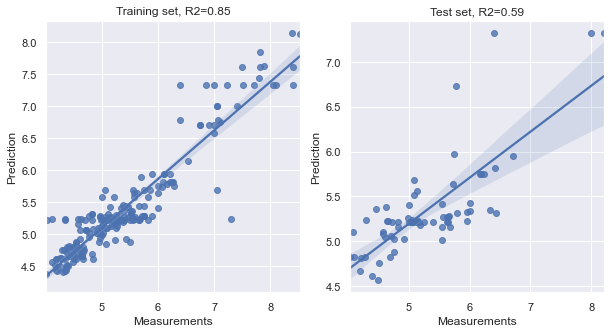

In [22]:
xgb_reg_all = GradientBoostingRegressor().fit(X_train, y_train)
evaluate_model(X_train, X_test, xgb_reg_all)

### Compare predicted values with measurements on t-SNE plots

In [23]:
p_ic50_predict = rf_reg_all.predict(fp_matrix)

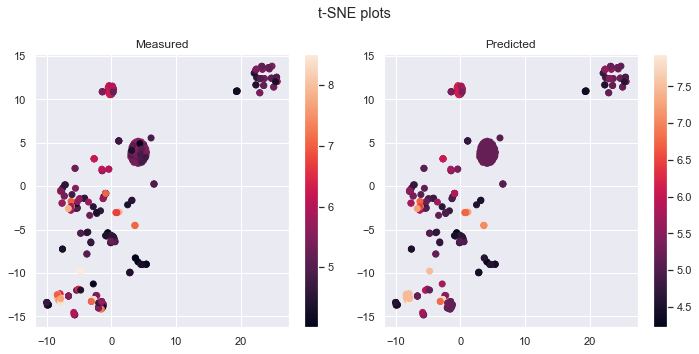

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('t-SNE plots')

im1 = ax1.scatter(Z_tsne[:, 0], Z_tsne[:, 1], c=p_ic50_vec)
ax1.set_title('Measured')
ax1.figure.colorbar(im1, ax=ax1)

im2 = ax2.scatter(Z_tsne[:, 0], Z_tsne[:, 1], c=p_ic50_predict)
ax2.set_title('Predicted')
ax2.figure.colorbar(im2, ax=ax2)

plt.tight_layout()
plt.show()

## Predict activities for new compounds

Here we load all compounds with ATC classification from ChEMBL:
* [ATC classification](https://en.wikipedia.org/wiki/Anatomical_Therapeutic_Chemical_Classification_System)
* [Query link](https://www.ebi.ac.uk/chembl/g/#browse/compounds/full_state/eyJsaXN0Ijp7InNldHRpbmdzX3BhdGgiOiJFU19JTkRFWEVTX05PX01BSU5fU0VBUkNILkNPTVBPVU5EX0NPT0xfQ0FSRFMiLCJjdXN0b21fcXVlcnkiOiIqIiwidXNlX2N1c3RvbV9xdWVyeSI6dHJ1ZSwic2VhcmNoX3Rlcm0iOiIiLCJhdF9sZWFzdF9vbmVfZmFjZXRfaXNfc2VsZWN0ZWQiOnRydWUsImZhY2V0c19zdGF0ZSI6eyJtb2xlY3VsZV90eXBlIjp7ImVzX2luZGV4IjoiY2hlbWJsX21vbGVjdWxlIiwiZXNfcHJvcGVydHlfbmFtZSI6Im1vbGVjdWxlX3R5cGUiLCJmYWNldGluZ190eXBlIjoiQ0FURUdPUlkiLCJwcm9wZXJ0eV90eXBlIjp7ImludGVnZXIiOmZhbHNlLCJ5ZWFyIjpudWxsLCJhZ2dyZWdhdGFibGUiOnRydWV9LCJpc1llYXIiOm51bGwsInNvcnQiOiJhc2MiLCJpbnRlcnZhbHMiOjIwLCJyZXBvcnRfY2FyZF9lbnRpdHkiOm51bGwsImZhY2V0aW5nX2tleXNfaW5vcmRlciI6WyItIE4vQSAtIiwiQW50aWJvZHkiLCJDZWxsIiwiRW56eW1lIiwiR2VuZSIsIk9saWdvbnVjbGVvdGlkZSIsIk9saWdvc2FjY2hhcmlkZSIsIlByb3RlaW4iLCJTbWFsbCBtb2xlY3VsZSIsIlVuY2xhc3NpZmllZCIsIlVua25vd24iXSwiZmFjZXRpbmdfZGF0YSI6eyJTbWFsbCBtb2xlY3VsZSI6eyJpbmRleCI6MCwiY291bnQiOjE5MjAwMjcsInNlbGVjdGVkIjp0cnVlLCJrZXlfZm9yX2h1bWFucyI6IlNtYWxsIG1vbGVjdWxlIiwia2V5IjoiU21hbGwgbW9sZWN1bGUiLCJpZCI6IlNtYWxsIG1vbGVjdWxlOjE5MjAwMjcifSwiLSBOL0EgLSI6eyJpbmRleCI6MSwiY291bnQiOjEyNDk1NSwic2VsZWN0ZWQiOmZhbHNlLCJrZXlfZm9yX2h1bWFucyI6Ii0gTi9BIC0iLCJrZXkiOiItIE4vQSAtIiwiaWQiOiItIE4vQSAtOjEyNDk1NSJ9LCJQcm90ZWluIjp7ImluZGV4IjoyLCJjb3VudCI6MjI2NTQsInNlbGVjdGVkIjpmYWxzZSwia2V5X2Zvcl9odW1hbnMiOiJQcm90ZWluIiwia2V5IjoiUHJvdGVpbiIsImlkIjoiUHJvdGVpbjoyMjY1NCJ9LCJVbmtub3duIjp7ImluZGV4IjozLCJjb3VudCI6MTc5MzAsInNlbGVjdGVkIjpmYWxzZSwia2V5X2Zvcl9odW1hbnMiOiJVbmtub3duIiwia2V5IjoiVW5rbm93biIsImlkIjoiVW5rbm93bjoxNzkzMCJ9LCJBbnRpYm9keSI6eyJpbmRleCI6NCwiY291bnQiOjg4Mywic2VsZWN0ZWQiOmZhbHNlLCJrZXlfZm9yX2h1bWFucyI6IkFudGlib2R5Iiwia2V5IjoiQW50aWJvZHkiLCJpZCI6IkFudGlib2R5Ojg4MyJ9LCJPbGlnb251Y2xlb3RpZGUiOnsiaW5kZXgiOjUsImNvdW50IjoxNDYsInNlbGVjdGVkIjpmYWxzZSwia2V5X2Zvcl9odW1hbnMiOiJPbGlnb251Y2xlb3RpZGUiLCJrZXkiOiJPbGlnb251Y2xlb3RpZGUiLCJpZCI6Ik9saWdvbnVjbGVvdGlkZToxNDYifSwiRW56eW1lIjp7ImluZGV4Ijo2LCJjb3VudCI6MTE4LCJzZWxlY3RlZCI6ZmFsc2UsImtleV9mb3JfaHVtYW5zIjoiRW56eW1lIiwia2V5IjoiRW56eW1lIiwiaWQiOiJFbnp5bWU6MTE4In0sIk9saWdvc2FjY2hhcmlkZSI6eyJpbmRleCI6NywiY291bnQiOjg2LCJzZWxlY3RlZCI6ZmFsc2UsImtleV9mb3JfaHVtYW5zIjoiT2xpZ29zYWNjaGFyaWRlIiwia2V5IjoiT2xpZ29zYWNjaGFyaWRlIiwiaWQiOiJPbGlnb3NhY2NoYXJpZGU6ODYifSwiR2VuZSI6eyJpbmRleCI6OCwiY291bnQiOjU2LCJzZWxlY3RlZCI6ZmFsc2UsImtleV9mb3JfaHVtYW5zIjoiR2VuZSIsImtleSI6IkdlbmUiLCJpZCI6IkdlbmU6NTYifSwiQ2VsbCI6eyJpbmRleCI6OSwiY291bnQiOjQxLCJzZWxlY3RlZCI6ZmFsc2UsImtleV9mb3JfaHVtYW5zIjoiQ2VsbCIsImtleSI6IkNlbGwiLCJpZCI6IkNlbGw6NDEifSwiVW5jbGFzc2lmaWVkIjp7ImluZGV4IjoxMCwiY291bnQiOjIsInNlbGVjdGVkIjpmYWxzZSwia2V5X2Zvcl9odW1hbnMiOiJVbmNsYXNzaWZpZWQiLCJrZXkiOiJVbmNsYXNzaWZpZWQiLCJpZCI6IlVuY2xhc3NpZmllZDoyIn19LCJpbnRlcnZhbHNMaW1pdHMiOm51bGx9LCJtYXhfcGhhc2UiOnsiZXNfaW5kZXgiOiJjaGVtYmxfbW9sZWN1bGUiLCJlc19wcm9wZXJ0eV9uYW1lIjoibWF4X3BoYXNlIiwiZmFjZXRpbmdfdHlwZSI6IklOVEVSVkFMIiwicHJvcGVydHlfdHlwZSI6eyJpbnRlZ2VyIjp0cnVlLCJ5ZWFyIjpudWxsLCJhZ2dyZWdhdGFibGUiOnRydWV9LCJpc1llYXIiOm51bGwsInNvcnQiOm51bGwsImludGVydmFscyI6bnVsbCwicmVwb3J0X2NhcmRfZW50aXR5IjpudWxsLCJmYWNldGluZ19rZXlzX2lub3JkZXIiOlsiMCIsIjEiLCIyIiwiMyIsIjQiXSwiZmFjZXRpbmdfZGF0YSI6eyIwIjp7Im1pbiI6MCwibWF4IjoxLCJpbmRleCI6MCwiY291bnQiOjYzNSwic2VsZWN0ZWQiOmZhbHNlLCJrZXlfZm9yX2h1bWFucyI6IjAiLCJrZXkiOiIwIiwiaWQiOiIwOjYzNSJ9LCIxIjp7Im1pbiI6MSwibWF4IjoyLCJpbmRleCI6MSwiY291bnQiOjEwLCJzZWxlY3RlZCI6ZmFsc2UsImtleV9mb3JfaHVtYW5zIjoiMSIsImtleSI6IjEiLCJpZCI6IjE6MTAifSwiMiI6eyJtaW4iOjIsIm1heCI6MywiaW5kZXgiOjIsImNvdW50Ijo0Miwic2VsZWN0ZWQiOmZhbHNlLCJrZXlfZm9yX2h1bWFucyI6IjIiLCJrZXkiOiIyIiwiaWQiOiIyOjQyIn0sIjMiOnsibWluIjozLCJtYXgiOjQsImluZGV4IjozLCJjb3VudCI6MTYyLCJzZWxlY3RlZCI6ZmFsc2UsImtleV9mb3JfaHVtYW5zIjoiMyIsImtleSI6IjMiLCJpZCI6IjM6MTYyIn0sIjQiOnsibWluIjo0LCJtYXgiOjUsImluZGV4Ijo0LCJjb3VudCI6MTg3NCwic2VsZWN0ZWQiOmZhbHNlLCJrZXlfZm9yX2h1bWFucyI6IjQiLCJrZXkiOiI0IiwiaWQiOiI0OjE4NzQifX0sImludGVydmFsc0xpbWl0cyI6WzAsMSwyLDMsNCw1XX0sIm1vbGVjdWxlX3Byb3BlcnRpZXMubnVtX3JvNV92aW9sYXRpb25zIjp7ImVzX2luZGV4IjoiY2hlbWJsX21vbGVjdWxlIiwiZXNfcHJvcGVydHlfbmFtZSI6Im1vbGVjdWxlX3Byb3BlcnRpZXMubnVtX3JvNV92aW9sYXRpb25zIiwiZmFjZXRpbmdfdHlwZSI6IklOVEVSVkFMIiwicHJvcGVydHlfdHlwZSI6eyJpbnRlZ2VyIjp0cnVlLCJ5ZWFyIjpudWxsLCJhZ2dyZWdhdGFibGUiOnRydWV9LCJpc1llYXIiOm51bGwsInNvcnQiOm51bGwsImludGVydmFscyI6bnVsbCwicmVwb3J0X2NhcmRfZW50aXR5IjpudWxsLCJmYWNldGluZ19rZXlzX2lub3JkZXIiOlsiMCIsIjEiLCIyIiwiMyIsIjQiXSwiZmFjZXRpbmdfZGF0YSI6eyIwIjp7Im1pbiI6MCwibWF4IjoxLCJpbmRleCI6MCwiY291bnQiOjE5NzMsInNlbGVjdGVkIjpmYWxzZSwia2V5X2Zvcl9odW1hbnMiOiIwIiwia2V5IjoiMCIsImlkIjoiMDoxOTczIn0sIjEiOnsibWluIjoxLCJtYXgiOjIsImluZGV4IjoxLCJjb3VudCI6MzE3LCJzZWxlY3RlZCI6ZmFsc2UsImtleV9mb3JfaHVtYW5zIjoiMSIsImtleSI6IjEiLCJpZCI6IjE6MzE3In0sIjIiOnsibWluIjoyLCJtYXgiOjMsImluZGV4IjoyLCJjb3VudCI6MTY4LCJzZWxlY3RlZCI6ZmFsc2UsImtleV9mb3JfaHVtYW5zIjoiMiIsImtleSI6IjIiLCJpZCI6IjI6MTY4In0sIjMiOnsibWluIjozLCJtYXgiOjQsImluZGV4IjozLCJjb3VudCI6NDQsInNlbGVjdGVkIjpmYWxzZSwia2V5X2Zvcl9odW1hbnMiOiIzIiwia2V5IjoiMyIsImlkIjoiMzo0NCJ9LCI0Ijp7Im1pbiI6NCwibWF4Ijo1LCJpbmRleCI6NCwiY291bnQiOjEsInNlbGVjdGVkIjpmYWxzZSwia2V5X2Zvcl9odW1hbnMiOiI0Iiwia2V5IjoiNCIsImlkIjoiNDoxIn19LCJpbnRlcnZhbHNMaW1pdHMiOlswLDEsMiwzLDQsNV19LCJtb2xlY3VsZV9wcm9wZXJ0aWVzLmZ1bGxfbXd0Ijp7ImVzX2luZGV4IjoiY2hlbWJsX21vbGVjdWxlIiwiZXNfcHJvcGVydHlfbmFtZSI6Im1vbGVjdWxlX3Byb3BlcnRpZXMuZnVsbF9td3QiLCJmYWNldGluZ190eXBlIjoiSU5URVJWQUwiLCJwcm9wZXJ0eV90eXBlIjp7ImludGVnZXIiOnRydWUsInllYXIiOm51bGwsImFnZ3JlZ2F0YWJsZSI6dHJ1ZX0sImlzWWVhciI6bnVsbCwic29ydCI6bnVsbCwiaW50ZXJ2YWxzIjpudWxsLCJyZXBvcnRfY2FyZF9lbnRpdHkiOm51bGwsImZhY2V0aW5nX2tleXNfaW5vcmRlciI6WyJbMTIuMDEgIHRvICA5OV0iLCJbMTAwICB0byAgMTk5XSIsIlsyMDAgIHRvICAyOTldIiwiWzMwMCAgdG8gIDM5OV0iLCJbNDAwICB0byAgNDk5XSIsIls1MDAgIHRvICA1OTldIiwiWzYwMCAgdG8gIDY5OV0iLCJbNzAwICB0byAgNzk5XSIsIls4MDAgIHRvICAyLDcxNS4zMl0iXSwiZmFjZXRpbmdfZGF0YSI6eyJbMTIuMDEgIHRvICA5OV0iOnsibWluIjoxMi4wMSwibWF4IjoxMDAsImluZGV4IjowLCJjb3VudCI6NDYsInNlbGVjdGVkIjpmYWxzZSwia2V5X2Zvcl9odW1hbnMiOiJbMTIuMDEgIHRvICA5OV0iLCJrZXkiOiJbMTIuMDEgIHRvICA5OV0iLCJpZCI6IlsxMi4wMSAgdG8gIDk5XTo0NiJ9LCJbMTAwICB0byAgMTk5XSI6eyJtaW4iOjEwMCwibWF4IjoyMDAsImluZGV4IjoxLCJjb3VudCI6MjkwLCJzZWxlY3RlZCI6ZmFsc2UsImtleV9mb3JfaHVtYW5zIjoiWzEwMCAgdG8gIDE5OV0iLCJrZXkiOiJbMTAwICB0byAgMTk5XSIsImlkIjoiWzEwMCAgdG8gIDE5OV06MjkwIn0sIlsyMDAgIHRvICAyOTldIjp7Im1pbiI6MjAwLCJtYXgiOjMwMCwiaW5kZXgiOjIsImNvdW50Ijo2OTYsInNlbGVjdGVkIjpmYWxzZSwia2V5X2Zvcl9odW1hbnMiOiJbMjAwICB0byAgMjk5XSIsImtleSI6IlsyMDAgIHRvICAyOTldIiwiaWQiOiJbMjAwICB0byAgMjk5XTo2OTYifSwiWzMwMCAgdG8gIDM5OV0iOnsibWluIjozMDAsIm1heCI6NDAwLCJpbmRleCI6MywiY291bnQiOjgwMSwic2VsZWN0ZWQiOmZhbHNlLCJrZXlfZm9yX2h1bWFucyI6IlszMDAgIHRvICAzOTldIiwia2V5IjoiWzMwMCAgdG8gIDM5OV0iLCJpZCI6IlszMDAgIHRvICAzOTldOjgwMSJ9LCJbNDAwICB0byAgNDk5XSI6eyJtaW4iOjQwMCwibWF4Ijo1MDAsImluZGV4Ijo0LCJjb3VudCI6NDkxLCJzZWxlY3RlZCI6ZmFsc2UsImtleV9mb3JfaHVtYW5zIjoiWzQwMCAgdG8gIDQ5OV0iLCJrZXkiOiJbNDAwICB0byAgNDk5XSIsImlkIjoiWzQwMCAgdG8gIDQ5OV06NDkxIn0sIls1MDAgIHRvICA1OTldIjp7Im1pbiI6NTAwLCJtYXgiOjYwMCwiaW5kZXgiOjUsImNvdW50IjoxNzcsInNlbGVjdGVkIjpmYWxzZSwia2V5X2Zvcl9odW1hbnMiOiJbNTAwICB0byAgNTk5XSIsImtleSI6Ils1MDAgIHRvICA1OTldIiwiaWQiOiJbNTAwICB0byAgNTk5XToxNzcifSwiWzYwMCAgdG8gIDY5OV0iOnsibWluIjo2MDAsIm1heCI6NzAwLCJpbmRleCI6NiwiY291bnQiOjcxLCJzZWxlY3RlZCI6ZmFsc2UsImtleV9mb3JfaHVtYW5zIjoiWzYwMCAgdG8gIDY5OV0iLCJrZXkiOiJbNjAwICB0byAgNjk5XSIsImlkIjoiWzYwMCAgdG8gIDY5OV06NzEifSwiWzcwMCAgdG8gIDc5OV0iOnsibWluIjo3MDAsIm1heCI6ODAwLCJpbmRleCI6NywiY291bnQiOjM3LCJzZWxlY3RlZCI6ZmFsc2UsImtleV9mb3JfaHVtYW5zIjoiWzcwMCAgdG8gIDc5OV0iLCJrZXkiOiJbNzAwICB0byAgNzk5XSIsImlkIjoiWzcwMCAgdG8gIDc5OV06MzcifSwiWzgwMCAgdG8gIDIsNzE1LjMyXSI6eyJtaW4iOjgwMCwibWF4IjoyNzE2LjMyLCJpbmRleCI6OCwiY291bnQiOjc4LCJzZWxlY3RlZCI6ZmFsc2UsImtleV9mb3JfaHVtYW5zIjoiWzgwMCAgdG8gIDIsNzE1LjMyXSIsImtleSI6Ils4MDAgIHRvICAyLDcxNS4zMl0iLCJpZCI6Ils4MDAgIHRvICAyLDcxNS4zMl06NzgifX0sImludGVydmFsc0xpbWl0cyI6WzEyLjAxLDEwMCwyMDAsMzAwLDQwMCw1MDAsNjAwLDcwMCw4MDAsMjcxNi4zMl19LCJtb2xlY3VsZV9wcm9wZXJ0aWVzLmFsb2dwIjp7ImVzX2luZGV4IjoiY2hlbWJsX21vbGVjdWxlIiwiZXNfcHJvcGVydHlfbmFtZSI6Im1vbGVjdWxlX3Byb3BlcnRpZXMuYWxvZ3AiLCJmYWNldGluZ190eXBlIjoiSU5URVJWQUwiLCJwcm9wZXJ0eV90eXBlIjp7ImludGVnZXIiOnRydWUsInllYXIiOm51bGwsImFnZ3JlZ2F0YWJsZSI6dHJ1ZX0sImlzWWVhciI6bnVsbCwic29ydCI6bnVsbCwiaW50ZXJ2YWxzIjpudWxsLCJyZXBvcnRfY2FyZF9lbnRpdHkiOm51bGwsImZhY2V0aW5nX2tleXNfaW5vcmRlciI6WyJbLTguOTAgIHRvICAtMV0iLCIwIiwiMSIsIjIiLCIzIiwiNCIsIjUiLCI2IiwiNyIsIls4ICB0byAgMTcuODVdIl0sImZhY2V0aW5nX2RhdGEiOnsiMCI6eyJtaW4iOjAsIm1heCI6MSwiaW5kZXgiOjEsImNvdW50IjoyNzIsInNlbGVjdGVkIjpmYWxzZSwia2V5X2Zvcl9odW1hbnMiOiIwIiwia2V5IjoiMCIsImlkIjoiMDoyNzIifSwiMSI6eyJtaW4iOjEsIm1heCI6MiwiaW5kZXgiOjIsImNvdW50IjozNzYsInNlbGVjdGVkIjpmYWxzZSwia2V5X2Zvcl9odW1hbnMiOiIxIiwia2V5IjoiMSIsImlkIjoiMTozNzYifSwiMiI6eyJtaW4iOjIsIm1heCI6MywiaW5kZXgiOjMsImNvdW50Ijo0ODAsInNlbGVjdGVkIjpmYWxzZSwia2V5X2Zvcl9odW1hbnMiOiIyIiwia2V5IjoiMiIsImlkIjoiMjo0ODAifSwiMyI6eyJtaW4iOjMsIm1heCI6NCwiaW5kZXgiOjQsImNvdW50Ijo0NjcsInNlbGVjdGVkIjpmYWxzZSwia2V5X2Zvcl9odW1hbnMiOiIzIiwia2V5IjoiMyIsImlkIjoiMzo0NjcifSwiNCI6eyJtaW4iOjQsIm1heCI6NSwiaW5kZXgiOjUsImNvdW50IjozNDQsInNlbGVjdGVkIjpmYWxzZSwia2V5X2Zvcl9odW1hbnMiOiI0Iiwia2V5IjoiNCIsImlkIjoiNDozNDQifSwiNSI6eyJtaW4iOjUsIm1heCI6NiwiaW5kZXgiOjYsImNvdW50IjoxNTcsInNlbGVjdGVkIjpmYWxzZSwia2V5X2Zvcl9odW1hbnMiOiI1Iiwia2V5IjoiNSIsImlkIjoiNToxNTcifSwiNiI6eyJtaW4iOjYsIm1heCI6NywiaW5kZXgiOjcsImNvdW50Ijo3Niwic2VsZWN0ZWQiOmZhbHNlLCJrZXlfZm9yX2h1bWFucyI6IjYiLCJrZXkiOiI2IiwiaWQiOiI2Ojc2In0sIjciOnsibWluIjo3LCJtYXgiOjgsImluZGV4Ijo4LCJjb3VudCI6MjAsInNlbGVjdGVkIjpmYWxzZSwia2V5X2Zvcl9odW1hbnMiOiI3Iiwia2V5IjoiNyIsImlkIjoiNzoyMCJ9LCJbLTguOTAgIHRvICAtMV0iOnsibWluIjotOC45LCJtYXgiOjAsImluZGV4IjowLCJjb3VudCI6Mjg3LCJzZWxlY3RlZCI6ZmFsc2UsImtleV9mb3JfaHVtYW5zIjoiWy04LjkwICB0byAgLTFdIiwia2V5IjoiWy04LjkwICB0byAgLTFdIiwiaWQiOiJbLTguOTAgIHRvICAtMV06Mjg3In0sIls4ICB0byAgMTcuODVdIjp7Im1pbiI6OCwibWF4IjoxOC44NSwiaW5kZXgiOjksImNvdW50IjoyNCwic2VsZWN0ZWQiOmZhbHNlLCJrZXlfZm9yX2h1bWFucyI6Ils4ICB0byAgMTcuODVdIiwia2V5IjoiWzggIHRvICAxNy44NV0iLCJpZCI6Ils4ICB0byAgMTcuODVdOjI0In19LCJpbnRlcnZhbHNMaW1pdHMiOlstOC45LDAsMSwyLDMsNCw1LDYsNyw4LDE4Ljg1XX0sIl9tZXRhZGF0YS5hdGNfY2xhc3NpZmljYXRpb25zLmxldmVsMV9kZXNjcmlwdGlvbiI6eyJlc19pbmRleCI6ImNoZW1ibF9tb2xlY3VsZSIsImVzX3Byb3BlcnR5X25hbWUiOiJfbWV0YWRhdGEuYXRjX2NsYXNzaWZpY2F0aW9ucy5sZXZlbDFfZGVzY3JpcHRpb24iLCJmYWNldGluZ190eXBlIjoiQ0FURUdPUlkiLCJwcm9wZXJ0eV90eXBlIjp7ImludGVnZXIiOmZhbHNlLCJ5ZWFyIjpudWxsLCJhZ2dyZWdhdGFibGUiOnRydWV9LCJpc1llYXIiOm51bGwsInNvcnQiOiJhc2MiLCJpbnRlcnZhbHMiOjIwLCJyZXBvcnRfY2FyZF9lbnRpdHkiOm51bGwsImZhY2V0aW5nX2tleXNfaW5vcmRlciI6WyItIE4vQSAtIiwiQSAtIEFMSU1FTlRBUlkgVFJBQ1QgQU5EIE1FVEFCT0xJU00iLCJCIC0gQkxPT0QgQU5EIEJMT09EIEZPUk1JTkcgT1JHQU5TIiwiQyAtIENBUkRJT1ZBU0NVTEFSIFNZU1RFTSIsIkQgLSBERVJNQVRPTE9HSUNBTFMiLCJHIC0gR0VOSVRPIFVSSU5BUlkgU1lTVEVNIEFORCBTRVggSE9STU9ORVMiLCJIIC0gU1lTVEVNSUMgSE9STU9OQUwgUFJFUEFSQVRJT05TLCBFWENMLiBTRVggSE9STU9ORVMgQU5EIElOU1VMSU5TIiwiSiAtIEFOVElJTkZFQ1RJVkVTIEZPUiBTWVNURU1JQyBVU0UiLCJMIC0gQU5USU5FT1BMQVNUSUMgQU5EIElNTVVOT01PRFVMQVRJTkcgQUdFTlRTIiwiTSAtIE1VU0NVTE8tU0tFTEVUQUwgU1lTVEVNIiwiTiAtIE5FUlZPVVMgU1lTVEVNIiwiUCAtIEFOVElQQVJBU0lUSUMgUFJPRFVDVFMsIElOU0VDVElDSURFUyBBTkQgUkVQRUxMRU5UUyIsIlIgLSBSRVNQSVJBVE9SWSBTWVNURU0iLCJTIC0gU0VOU09SWSBPUkdBTlMiLCJWIC0gVkFSSU9VUyJdLCJmYWNldGluZ19kYXRhIjp7Ii0gTi9BIC0iOnsiaW5kZXgiOjAsImNvdW50IjoxOTE3MTQyLCJzZWxlY3RlZCI6ZmFsc2UsImtleV9mb3JfaHVtYW5zIjoiLSBOL0EgLSIsImtleSI6Ii0gTi9BIC0iLCJpZCI6Ii0gTi9BIC06MTkxNzE0MiJ9LCJOIC0gTkVSVk9VUyBTWVNURU0iOnsiaW5kZXgiOjEsImNvdW50Ijo1MDcsInNlbGVjdGVkIjp0cnVlLCJrZXlfZm9yX2h1bWFucyI6Ik4gLSBORVJWT1VTIFNZU1RFTSIsImtleSI6Ik4gLSBORVJWT1VTIFNZU1RFTSIsImlkIjoiTiAtIE5FUlZPVVMgU1lTVEVNOjUwNyJ9LCJBIC0gQUxJTUVOVEFSWSBUUkFDVCBBTkQgTUVUQUJPTElTTSI6eyJpbmRleCI6MiwiY291bnQiOjM5OCwic2VsZWN0ZWQiOnRydWUsImtleV9mb3JfaHVtYW5zIjoiQSAtIEFMSU1FTlRBUlkgVFJBQ1QgQU5EIE1FVEFCT0xJU00iLCJrZXkiOiJBIC0gQUxJTUVOVEFSWSBUUkFDVCBBTkQgTUVUQUJPTElTTSIsImlkIjoiQSAtIEFMSU1FTlRBUlkgVFJBQ1QgQU5EIE1FVEFCT0xJU006Mzk4In0sIkMgLSBDQVJESU9WQVNDVUxBUiBTWVNURU0iOnsiaW5kZXgiOjMsImNvdW50IjozOTcsInNlbGVjdGVkIjp0cnVlLCJrZXlfZm9yX2h1bWFucyI6IkMgLSBDQVJESU9WQVNDVUxBUiBTWVNURU0iLCJrZXkiOiJDIC0gQ0FSRElPVkFTQ1VMQVIgU1lTVEVNIiwiaWQiOiJDIC0gQ0FSRElPVkFTQ1VMQVIgU1lTVEVNOjM5NyJ9LCJKIC0gQU5USUlORkVDVElWRVMgRk9SIFNZU1RFTUlDIFVTRSI6eyJpbmRleCI6NCwiY291bnQiOjMyNCwic2VsZWN0ZWQiOnRydWUsImtleV9mb3JfaHVtYW5zIjoiSiAtIEFOVElJTkZFQ1RJVkVTIEZPUiBTWVNURU1JQyBVU0UiLCJrZXkiOiJKIC0gQU5USUlORkVDVElWRVMgRk9SIFNZU1RFTUlDIFVTRSIsImlkIjoiSiAtIEFOVElJTkZFQ1RJVkVTIEZPUiBTWVNURU1JQyBVU0U6MzI0In0sIkQgLSBERVJNQVRPTE9HSUNBTFMiOnsiaW5kZXgiOjUsImNvdW50IjoyODUsInNlbGVjdGVkIjp0cnVlLCJrZXlfZm9yX2h1bWFucyI6IkQgLSBERVJNQVRPTE9HSUNBTFMiLCJrZXkiOiJEIC0gREVSTUFUT0xPR0lDQUxTIiwiaWQiOiJEIC0gREVSTUFUT0xPR0lDQUxTOjI4NSJ9LCJSIC0gUkVTUElSQVRPUlkgU1lTVEVNIjp7ImluZGV4Ijo2LCJjb3VudCI6MjU3LCJzZWxlY3RlZCI6dHJ1ZSwia2V5X2Zvcl9odW1hbnMiOiJSIC0gUkVTUElSQVRPUlkgU1lTVEVNIiwia2V5IjoiUiAtIFJFU1BJUkFUT1JZIFNZU1RFTSIsImlkIjoiUiAtIFJFU1BJUkFUT1JZIFNZU1RFTToyNTcifSwiTCAtIEFOVElORU9QTEFTVElDIEFORCBJTU1VTk9NT0RVTEFUSU5HIEFHRU5UUyI6eyJpbmRleCI6NywiY291bnQiOjIzOCwic2VsZWN0ZWQiOnRydWUsImtleV9mb3JfaHVtYW5zIjoiTCAtIEFOVElORU9QTEFTVElDIEFORCBJTU1VTk9NT0RVTEFUSU5HIEFHRU5UUyIsImtleSI6IkwgLSBBTlRJTkVPUExBU1RJQyBBTkQgSU1NVU5PTU9EVUxBVElORyBBR0VOVFMiLCJpZCI6IkwgLSBBTlRJTkVPUExBU1RJQyBBTkQgSU1NVU5PTU9EVUxBVElORyBBR0VOVFM6MjM4In0sIlMgLSBTRU5TT1JZIE9SR0FOUyI6eyJpbmRleCI6OCwiY291bnQiOjE5Niwic2VsZWN0ZWQiOnRydWUsImtleV9mb3JfaHVtYW5zIjoiUyAtIFNFTlNPUlkgT1JHQU5TIiwia2V5IjoiUyAtIFNFTlNPUlkgT1JHQU5TIiwiaWQiOiJTIC0gU0VOU09SWSBPUkdBTlM6MTk2In0sIlYgLSBWQVJJT1VTIjp7ImluZGV4Ijo5LCJjb3VudCI6MTc4LCJzZWxlY3RlZCI6dHJ1ZSwia2V5X2Zvcl9odW1hbnMiOiJWIC0gVkFSSU9VUyIsImtleSI6IlYgLSBWQVJJT1VTIiwiaWQiOiJWIC0gVkFSSU9VUzoxNzgifSwiRyAtIEdFTklUTyBVUklOQVJZIFNZU1RFTSBBTkQgU0VYIEhPUk1PTkVTIjp7ImluZGV4IjoxMCwiY291bnQiOjE3NCwic2VsZWN0ZWQiOnRydWUsImtleV9mb3JfaHVtYW5zIjoiRyAtIEdFTklUTyBVUklOQVJZIFNZU1RFTSBBTkQgU0VYIEhPUk1PTkVTIiwia2V5IjoiRyAtIEdFTklUTyBVUklOQVJZIFNZU1RFTSBBTkQgU0VYIEhPUk1PTkVTIiwiaWQiOiJHIC0gR0VOSVRPIFVSSU5BUlkgU1lTVEVNIEFORCBTRVggSE9STU9ORVM6MTc0In0sIk0gLSBNVVNDVUxPLVNLRUxFVEFMIFNZU1RFTSI6eyJpbmRleCI6MTEsImNvdW50IjoxNDcsInNlbGVjdGVkIjp0cnVlLCJrZXlfZm9yX2h1bWFucyI6Ik0gLSBNVVNDVUxPLVNLRUxFVEFMIFNZU1RFTSIsImtleSI6Ik0gLSBNVVNDVUxPLVNLRUxFVEFMIFNZU1RFTSIsImlkIjoiTSAtIE1VU0NVTE8tU0tFTEVUQUwgU1lTVEVNOjE0NyJ9LCJCIC0gQkxPT0QgQU5EIEJMT09EIEZPUk1JTkcgT1JHQU5TIjp7ImluZGV4IjoxMiwiY291bnQiOjExNCwic2VsZWN0ZWQiOnRydWUsImtleV9mb3JfaHVtYW5zIjoiQiAtIEJMT09EIEFORCBCTE9PRCBGT1JNSU5HIE9SR0FOUyIsImtleSI6IkIgLSBCTE9PRCBBTkQgQkxPT0QgRk9STUlORyBPUkdBTlMiLCJpZCI6IkIgLSBCTE9PRCBBTkQgQkxPT0QgRk9STUlORyBPUkdBTlM6MTE0In0sIlAgLSBBTlRJUEFSQVNJVElDIFBST0RVQ1RTLCBJTlNFQ1RJQ0lERVMgQU5EIFJFUEVMTEVOVFMiOnsiaW5kZXgiOjEzLCJjb3VudCI6MTAzLCJzZWxlY3RlZCI6dHJ1ZSwia2V5X2Zvcl9odW1hbnMiOiJQIC0gQU5USVBBUkFTSVRJQyBQUk9EVUNUUywgSU5TRUNUSUNJREVTIEFORCBSRVBFTExFTlRTIiwia2V5IjoiUCAtIEFOVElQQVJBU0lUSUMgUFJPRFVDVFMsIElOU0VDVElDSURFUyBBTkQgUkVQRUxMRU5UUyIsImlkIjoiUCAtIEFOVElQQVJBU0lUSUMgUFJPRFVDVFMsIElOU0VDVElDSURFUyBBTkQgUkVQRUxMRU5UUzoxMDMifSwiSCAtIFNZU1RFTUlDIEhPUk1PTkFMIFBSRVBBUkFUSU9OUywgRVhDTC4gU0VYIEhPUk1PTkVTIEFORCBJTlNVTElOUyI6eyJpbmRleCI6MTQsImNvdW50Ijo1NCwic2VsZWN0ZWQiOnRydWUsImtleV9mb3JfaHVtYW5zIjoiSCAtIFNZU1RFTUlDIEhPUk1PTkFMIFBSRVBBUkFUSU9OUywgRVhDTC4gU0VYIEhPUk1PTkVTIEFORCBJTlNVTElOUyIsImtleSI6IkggLSBTWVNURU1JQyBIT1JNT05BTCBQUkVQQVJBVElPTlMsIEVYQ0wuIFNFWCBIT1JNT05FUyBBTkQgSU5TVUxJTlMiLCJpZCI6IkggLSBTWVNURU1JQyBIT1JNT05BTCBQUkVQQVJBVElPTlMsIEVYQ0wuIFNFWCBIT1JNT05FUyBBTkQgSU5TVUxJTlM6NTQifX0sImludGVydmFsc0xpbWl0cyI6bnVsbH0sIl9tZXRhZGF0YS5hdGNfY2xhc3NpZmljYXRpb25zLmxldmVsMl9kZXNjcmlwdGlvbiI6eyJlc19pbmRleCI6ImNoZW1ibF9tb2xlY3VsZSIsImVzX3Byb3BlcnR5X25hbWUiOiJfbWV0YWRhdGEuYXRjX2NsYXNzaWZpY2F0aW9ucy5sZXZlbDJfZGVzY3JpcHRpb24iLCJmYWNldGluZ190eXBlIjoiQ0FURUdPUlkiLCJwcm9wZXJ0eV90eXBlIjp7ImludGVnZXIiOmZhbHNlLCJ5ZWFyIjpudWxsLCJhZ2dyZWdhdGFibGUiOnRydWV9LCJpc1llYXIiOm51bGwsInNvcnQiOiJhc2MiLCJpbnRlcnZhbHMiOjIwLCJyZXBvcnRfY2FyZF9lbnRpdHkiOm51bGwsImZhY2V0aW5nX2tleXNfaW5vcmRlciI6WyJBMDMgLSBEUlVHUyBGT1IgRlVOQ1RJT05BTCBHQVNUUk9JTlRFU1RJTkFMIERJU09SREVSUyIsIkEwNyAtIEFOVElESUFSUkhFQUxTLCBJTlRFU1RJTkFMIEFOVElJTkZMQU1NQVRPUlkvQU5USUlORkVDVElWRSBBR0VOVFMiLCJDMDEgLSBDQVJESUFDIFRIRVJBUFkiLCJEMDcgLSBDT1JUSUNPU1RFUk9JRFMsIERFUk1BVE9MT0dJQ0FMIFBSRVBBUkFUSU9OUyIsIkcwMSAtIEdZTkVDT0xPR0lDQUwgQU5USUlORkVDVElWRVMgQU5EIEFOVElTRVBUSUNTIiwiRzAzIC0gU0VYIEhPUk1PTkVTIEFORCBNT0RVTEFUT1JTIE9GIFRIRSBHRU5JVEFMIFNZU1RFTSIsIkowMSAtIEFOVElCQUNURVJJQUxTIEZPUiBTWVNURU1JQyBVU0UiLCJKMDUgLSBBTlRJVklSQUxTIEZPUiBTWVNURU1JQyBVU0UiLCJMMDEgLSBBTlRJTkVPUExBU1RJQyBBR0VOVFMiLCJNMDEgLSBBTlRJSU5GTEFNTUFUT1JZIEFORCBBTlRJUkhFVU1BVElDIFBST0RVQ1RTIiwiTjAxIC0gQU5FU1RIRVRJQ1MiLCJOMDIgLSBBTkFMR0VTSUNTIiwiTjA1IC0gUFNZQ0hPTEVQVElDUyIsIk4wNiAtIFBTWUNIT0FOQUxFUFRJQ1MiLCJPdGhlciBDYXRlZ29yaWVzIiwiUDAxIC0gQU5USVBST1RPWk9BTFMiLCJSMDEgLSBOQVNBTCBQUkVQQVJBVElPTlMiLCJSMDMgLSBEUlVHUyBGT1IgT0JTVFJVQ1RJVkUgQUlSV0FZIERJU0VBU0VTIiwiUjA1IC0gQ09VR0ggQU5EIENPTEQgUFJFUEFSQVRJT05TIiwiUjA2IC0gQU5USUhJU1RBTUlORVMgRk9SIFNZU1RFTUlDIFVTRSIsIlMwMSAtIE9QSFRIQUxNT0xPR0lDQUxTIl0sImZhY2V0aW5nX2RhdGEiOnsiSjAxIC0gQU5USUJBQ1RFUklBTFMgRk9SIFNZU1RFTUlDIFVTRSI6eyJpbmRleCI6MCwiY291bnQiOjIxOSwic2VsZWN0ZWQiOmZhbHNlLCJrZXlfZm9yX2h1bWFucyI6IkowMSAtIEFOVElCQUNURVJJQUxTIEZPUiBTWVNURU1JQyBVU0UiLCJrZXkiOiJKMDEgLSBBTlRJQkFDVEVSSUFMUyBGT1IgU1lTVEVNSUMgVVNFIiwiaWQiOiJKMDEgLSBBTlRJQkFDVEVSSUFMUyBGT1IgU1lTVEVNSUMgVVNFOjIxOSJ9LCJTMDEgLSBPUEhUSEFMTU9MT0dJQ0FMUyI6eyJpbmRleCI6MSwiY291bnQiOjE4OSwic2VsZWN0ZWQiOmZhbHNlLCJrZXlfZm9yX2h1bWFucyI6IlMwMSAtIE9QSFRIQUxNT0xPR0lDQUxTIiwia2V5IjoiUzAxIC0gT1BIVEhBTE1PTE9HSUNBTFMiLCJpZCI6IlMwMSAtIE9QSFRIQUxNT0xPR0lDQUxTOjE4OSJ9LCJMMDEgLSBBTlRJTkVPUExBU1RJQyBBR0VOVFMiOnsiaW5kZXgiOjIsImNvdW50IjoxODgsInNlbGVjdGVkIjpmYWxzZSwia2V5X2Zvcl9odW1hbnMiOiJMMDEgLSBBTlRJTkVPUExBU1RJQyBBR0VOVFMiLCJrZXkiOiJMMDEgLSBBTlRJTkVPUExBU1RJQyBBR0VOVFMiLCJpZCI6IkwwMSAtIEFOVElORU9QTEFTVElDIEFHRU5UUzoxODgifSwiTjA1IC0gUFNZQ0hPTEVQVElDUyI6eyJpbmRleCI6MywiY291bnQiOjE2OCwic2VsZWN0ZWQiOmZhbHNlLCJrZXlfZm9yX2h1bWFucyI6Ik4wNSAtIFBTWUNIT0xFUFRJQ1MiLCJrZXkiOiJOMDUgLSBQU1lDSE9MRVBUSUNTIiwiaWQiOiJOMDUgLSBQU1lDSE9MRVBUSUNTOjE2OCJ9LCJDMDEgLSBDQVJESUFDIFRIRVJBUFkiOnsiaW5kZXgiOjQsImNvdW50IjoxMTYsInNlbGVjdGVkIjpmYWxzZSwia2V5X2Zvcl9odW1hbnMiOiJDMDEgLSBDQVJESUFDIFRIRVJBUFkiLCJrZXkiOiJDMDEgLSBDQVJESUFDIFRIRVJBUFkiLCJpZCI6IkMwMSAtIENBUkRJQUMgVEhFUkFQWToxMTYifSwiTjA2IC0gUFNZQ0hPQU5BTEVQVElDUyI6eyJpbmRleCI6NSwiY291bnQiOjEwNSwic2VsZWN0ZWQiOmZhbHNlLCJrZXlfZm9yX2h1bWFucyI6Ik4wNiAtIFBTWUNIT0FOQUxFUFRJQ1MiLCJrZXkiOiJOMDYgLSBQU1lDSE9BTkFMRVBUSUNTIiwiaWQiOiJOMDYgLSBQU1lDSE9BTkFMRVBUSUNTOjEwNSJ9LCJNMDEgLSBBTlRJSU5GTEFNTUFUT1JZIEFORCBBTlRJUkhFVU1BVElDIFBST0RVQ1RTIjp7ImluZGV4Ijo2LCJjb3VudCI6NzYsInNlbGVjdGVkIjpmYWxzZSwia2V5X2Zvcl9odW1hbnMiOiJNMDEgLSBBTlRJSU5GTEFNTUFUT1JZIEFORCBBTlRJUkhFVU1BVElDIFBST0RVQ1RTIiwia2V5IjoiTTAxIC0gQU5USUlORkxBTU1BVE9SWSBBTkQgQU5USVJIRVVNQVRJQyBQUk9EVUNUUyIsImlkIjoiTTAxIC0gQU5USUlORkxBTU1BVE9SWSBBTkQgQU5USVJIRVVNQVRJQyBQUk9EVUNUUzo3NiJ9LCJOMDIgLSBBTkFMR0VTSUNTIjp7ImluZGV4Ijo3LCJjb3VudCI6NzMsInNlbGVjdGVkIjpmYWxzZSwia2V5X2Zvcl9odW1hbnMiOiJOMDIgLSBBTkFMR0VTSUNTIiwia2V5IjoiTjAyIC0gQU5BTEdFU0lDUyIsImlkIjoiTjAyIC0gQU5BTEdFU0lDUzo3MyJ9LCJKMDUgLSBBTlRJVklSQUxTIEZPUiBTWVNURU1JQyBVU0UiOnsiaW5kZXgiOjgsImNvdW50Ijo3MSwic2VsZWN0ZWQiOmZhbHNlLCJrZXlfZm9yX2h1bWFucyI6IkowNSAtIEFOVElWSVJBTFMgRk9SIFNZU1RFTUlDIFVTRSIsImtleSI6IkowNSAtIEFOVElWSVJBTFMgRk9SIFNZU1RFTUlDIFVTRSIsImlkIjoiSjA1IC0gQU5USVZJUkFMUyBGT1IgU1lTVEVNSUMgVVNFOjcxIn0sIkEwMyAtIERSVUdTIEZPUiBGVU5DVElPTkFMIEdBU1RST0lOVEVTVElOQUwgRElTT1JERVJTIjp7ImluZGV4Ijo5LCJjb3VudCI6NzAsInNlbGVjdGVkIjpmYWxzZSwia2V5X2Zvcl9odW1hbnMiOiJBMDMgLSBEUlVHUyBGT1IgRlVOQ1RJT05BTCBHQVNUUk9JTlRFU1RJTkFMIERJU09SREVSUyIsImtleSI6IkEwMyAtIERSVUdTIEZPUiBGVU5DVElPTkFMIEdBU1RST0lOVEVTVElOQUwgRElTT1JERVJTIiwiaWQiOiJBMDMgLSBEUlVHUyBGT1IgRlVOQ1RJT05BTCBHQVNUUk9JTlRFU1RJTkFMIERJU09SREVSUzo3MCJ9LCJSMDMgLSBEUlVHUyBGT1IgT0JTVFJVQ1RJVkUgQUlSV0FZIERJU0VBU0VTIjp7ImluZGV4IjoxMCwiY291bnQiOjY5LCJzZWxlY3RlZCI6ZmFsc2UsImtleV9mb3JfaHVtYW5zIjoiUjAzIC0gRFJVR1MgRk9SIE9CU1RSVUNUSVZFIEFJUldBWSBESVNFQVNFUyIsImtleSI6IlIwMyAtIERSVUdTIEZPUiBPQlNUUlVDVElWRSBBSVJXQVkgRElTRUFTRVMiLCJpZCI6IlIwMyAtIERSVUdTIEZPUiBPQlNUUlVDVElWRSBBSVJXQVkgRElTRUFTRVM6NjkifSwiUjA2IC0gQU5USUhJU1RBTUlORVMgRk9SIFNZU1RFTUlDIFVTRSI6eyJpbmRleCI6MTEsImNvdW50Ijo2NCwic2VsZWN0ZWQiOmZhbHNlLCJrZXlfZm9yX2h1bWFucyI6IlIwNiAtIEFOVElISVNUQU1JTkVTIEZPUiBTWVNURU1JQyBVU0UiLCJrZXkiOiJSMDYgLSBBTlRJSElTVEFNSU5FUyBGT1IgU1lTVEVNSUMgVVNFIiwiaWQiOiJSMDYgLSBBTlRJSElTVEFNSU5FUyBGT1IgU1lTVEVNSUMgVVNFOjY0In0sIkcwMyAtIFNFWCBIT1JNT05FUyBBTkQgTU9EVUxBVE9SUyBPRiBUSEUgR0VOSVRBTCBTWVNURU0iOnsiaW5kZXgiOjEyLCJjb3VudCI6NjIsInNlbGVjdGVkIjpmYWxzZSwia2V5X2Zvcl9odW1hbnMiOiJHMDMgLSBTRVggSE9STU9ORVMgQU5EIE1PRFVMQVRPUlMgT0YgVEhFIEdFTklUQUwgU1lTVEVNIiwia2V5IjoiRzAzIC0gU0VYIEhPUk1PTkVTIEFORCBNT0RVTEFUT1JTIE9GIFRIRSBHRU5JVEFMIFNZU1RFTSIsImlkIjoiRzAzIC0gU0VYIEhPUk1PTkVTIEFORCBNT0RVTEFUT1JTIE9GIFRIRSBHRU5JVEFMIFNZU1RFTTo2MiJ9LCJEMDcgLSBDT1JUSUNPU1RFUk9JRFMsIERFUk1BVE9MT0dJQ0FMIFBSRVBBUkFUSU9OUyI6eyJpbmRleCI6MTMsImNvdW50Ijo1OCwic2VsZWN0ZWQiOmZhbHNlLCJrZXlfZm9yX2h1bWFucyI6IkQwNyAtIENPUlRJQ09TVEVST0lEUywgREVSTUFUT0xPR0lDQUwgUFJFUEFSQVRJT05TIiwia2V5IjoiRDA3IC0gQ09SVElDT1NURVJPSURTLCBERVJNQVRPTE9HSUNBTCBQUkVQQVJBVElPTlMiLCJpZCI6IkQwNyAtIENPUlRJQ09TVEVST0lEUywgREVSTUFUT0xPR0lDQUwgUFJFUEFSQVRJT05TOjU4In0sIlAwMSAtIEFOVElQUk9UT1pPQUxTIjp7ImluZGV4IjoxNCwiY291bnQiOjU2LCJzZWxlY3RlZCI6ZmFsc2UsImtleV9mb3JfaHVtYW5zIjoiUDAxIC0gQU5USVBST1RPWk9BTFMiLCJrZXkiOiJQMDEgLSBBTlRJUFJPVE9aT0FMUyIsImlkIjoiUDAxIC0gQU5USVBST1RPWk9BTFM6NTYifSwiUjAxIC0gTkFTQUwgUFJFUEFSQVRJT05TIjp7ImluZGV4IjoxNSwiY291bnQiOjU2LCJzZWxlY3RlZCI6ZmFsc2UsImtleV9mb3JfaHVtYW5zIjoiUjAxIC0gTkFTQUwgUFJFUEFSQVRJT05TIiwia2V5IjoiUjAxIC0gTkFTQUwgUFJFUEFSQVRJT05TIiwiaWQiOiJSMDEgLSBOQVNBTCBQUkVQQVJBVElPTlM6NTYifSwiUjA1IC0gQ09VR0ggQU5EIENPTEQgUFJFUEFSQVRJT05TIjp7ImluZGV4IjoxNiwiY291bnQiOjU1LCJzZWxlY3RlZCI6ZmFsc2UsImtleV9mb3JfaHVtYW5zIjoiUjA1IC0gQ09VR0ggQU5EIENPTEQgUFJFUEFSQVRJT05TIiwia2V5IjoiUjA1IC0gQ09VR0ggQU5EIENPTEQgUFJFUEFSQVRJT05TIiwiaWQiOiJSMDUgLSBDT1VHSCBBTkQgQ09MRCBQUkVQQVJBVElPTlM6NTUifSwiQTA3IC0gQU5USURJQVJSSEVBTFMsIElOVEVTVElOQUwgQU5USUlORkxBTU1BVE9SWS9BTlRJSU5GRUNUSVZFIEFHRU5UUyI6eyJpbmRleCI6MTcsImNvdW50Ijo1Mywic2VsZWN0ZWQiOmZhbHNlLCJrZXlfZm9yX2h1bWFucyI6IkEwNyAtIEFOVElESUFSUkhFQUxTLCBJTlRFU1RJTkFMIEFOVElJTkZMQU1NQVRPUlkvQU5USUlORkVDVElWRSBBR0VOVFMiLCJrZXkiOiJBMDcgLSBBTlRJRElBUlJIRUFMUywgSU5URVNUSU5BTCBBTlRJSU5GTEFNTUFUT1JZL0FOVElJTkZFQ1RJVkUgQUdFTlRTIiwiaWQiOiJBMDcgLSBBTlRJRElBUlJIRUFMUywgSU5URVNUSU5BTCBBTlRJSU5GTEFNTUFUT1JZL0FOVElJTkZFQ1RJVkUgQUdFTlRTOjUzIn0sIkcwMSAtIEdZTkVDT0xPR0lDQUwgQU5USUlORkVDVElWRVMgQU5EIEFOVElTRVBUSUNTIjp7ImluZGV4IjoxOCwiY291bnQiOjUxLCJzZWxlY3RlZCI6ZmFsc2UsImtleV9mb3JfaHVtYW5zIjoiRzAxIC0gR1lORUNPTE9HSUNBTCBBTlRJSU5GRUNUSVZFUyBBTkQgQU5USVNFUFRJQ1MiLCJrZXkiOiJHMDEgLSBHWU5FQ09MT0dJQ0FMIEFOVElJTkZFQ1RJVkVTIEFORCBBTlRJU0VQVElDUyIsImlkIjoiRzAxIC0gR1lORUNPTE9HSUNBTCBBTlRJSU5GRUNUSVZFUyBBTkQgQU5USVNFUFRJQ1M6NTEifSwiTjAxIC0gQU5FU1RIRVRJQ1MiOnsiaW5kZXgiOjE5LCJjb3VudCI6NDgsInNlbGVjdGVkIjpmYWxzZSwia2V5X2Zvcl9odW1hbnMiOiJOMDEgLSBBTkVTVEhFVElDUyIsImtleSI6Ik4wMSAtIEFORVNUSEVUSUNTIiwiaWQiOiJOMDEgLSBBTkVTVEhFVElDUzo0OCJ9LCJPdGhlciBDYXRlZ29yaWVzIjp7ImluZGV4IjoyMCwiY291bnQiOjE1MjIsInNlbGVjdGVkIjpmYWxzZSwia2V5X2Zvcl9odW1hbnMiOiJPdGhlciBDYXRlZ29yaWVzIiwia2V5IjoiT3RoZXIgQ2F0ZWdvcmllcyIsImlkIjoiT3RoZXIgQ2F0ZWdvcmllczoxNTIyIn19LCJpbnRlcnZhbHNMaW1pdHMiOm51bGx9LCJfbWV0YWRhdGEucmVsYXRlZF90YXJnZXRzLmNvdW50Ijp7ImVzX2luZGV4IjoiY2hlbWJsX21vbGVjdWxlIiwiZXNfcHJvcGVydHlfbmFtZSI6Il9tZXRhZGF0YS5yZWxhdGVkX3RhcmdldHMuY291bnQiLCJmYWNldGluZ190eXBlIjoiSU5URVJWQUwiLCJwcm9wZXJ0eV90eXBlIjp7ImludGVnZXIiOnRydWUsInllYXIiOm51bGwsImFnZ3JlZ2F0YWJsZSI6dHJ1ZX0sImlzWWVhciI6bnVsbCwic29ydCI6bnVsbCwiaW50ZXJ2YWxzIjpudWxsLCJyZXBvcnRfY2FyZF9lbnRpdHkiOm51bGwsImZhY2V0aW5nX2tleXNfaW5vcmRlciI6WyJbMSAgdG8gIDJdIiwiWzMgIHRvICA1XSIsIls2ICB0byAgOV0iLCJbMTAgIHRvICAxNl0iLCJbMTcgIHRvICAyNF0iLCJbMjUgIHRvICA0MF0iLCJbNDEgIHRvICAxMDddIiwiWzEwOCAgdG8gIDE0NF0iLCJbMTQ1ICB0byAgMjAyXSIsIlsyMDMgIHRvICAxLDMyOF0iXSwiZmFjZXRpbmdfZGF0YSI6eyJbMSAgdG8gIDJdIjp7Im1pbiI6MSwibWF4IjozLCJpbmRleCI6MCwiY291bnQiOjIyOSwic2VsZWN0ZWQiOmZhbHNlLCJrZXlfZm9yX2h1bWFucyI6IlsxICB0byAgMl0iLCJrZXkiOiJbMSAgdG8gIDJdIiwiaWQiOiJbMSAgdG8gIDJdOjIyOSJ9LCJbMyAgdG8gIDVdIjp7Im1pbiI6MywibWF4Ijo2LCJpbmRleCI6MSwiY291bnQiOjIzMSwic2VsZWN0ZWQiOmZhbHNlLCJrZXlfZm9yX2h1bWFucyI6IlszICB0byAgNV0iLCJrZXkiOiJbMyAgdG8gIDVdIiwiaWQiOiJbMyAgdG8gIDVdOjIzMSJ9LCJbNiAgdG8gIDldIjp7Im1pbiI6NiwibWF4IjoxMCwiaW5kZXgiOjIsImNvdW50IjoyMzEsInNlbGVjdGVkIjpmYWxzZSwia2V5X2Zvcl9odW1hbnMiOiJbNiAgdG8gIDldIiwia2V5IjoiWzYgIHRvICA5XSIsImlkIjoiWzYgIHRvICA5XToyMzEifSwiWzEwICB0byAgMTZdIjp7Im1pbiI6MTAsIm1heCI6MTcsImluZGV4IjozLCJjb3VudCI6MjQ3LCJzZWxlY3RlZCI6ZmFsc2UsImtleV9mb3JfaHVtYW5zIjoiWzEwICB0byAgMTZdIiwia2V5IjoiWzEwICB0byAgMTZdIiwiaWQiOiJbMTAgIHRvICAxNl06MjQ3In0sIlsxNyAgdG8gIDI0XSI6eyJtaW4iOjE3LCJtYXgiOjI1LCJpbmRleCI6NCwiY291bnQiOjIzNCwic2VsZWN0ZWQiOmZhbHNlLCJrZXlfZm9yX2h1bWFucyI6IlsxNyAgdG8gIDI0XSIsImtleSI6IlsxNyAgdG8gIDI0XSIsImlkIjoiWzE3ICB0byAgMjRdOjIzNCJ9LCJbMjUgIHRvICA0MF0iOnsibWluIjoyNSwibWF4Ijo0MSwiaW5kZXgiOjUsImNvdW50IjoyNDAsInNlbGVjdGVkIjpmYWxzZSwia2V5X2Zvcl9odW1hbnMiOiJbMjUgIHRvICA0MF0iLCJrZXkiOiJbMjUgIHRvICA0MF0iLCJpZCI6IlsyNSAgdG8gIDQwXToyNDAifSwiWzQxICB0byAgMTA3XSI6eyJtaW4iOjQxLCJtYXgiOjEwOCwiaW5kZXgiOjYsImNvdW50IjoyMzQsInNlbGVjdGVkIjpmYWxzZSwia2V5X2Zvcl9odW1hbnMiOiJbNDEgIHRvICAxMDddIiwia2V5IjoiWzQxICB0byAgMTA3XSIsImlkIjoiWzQxICB0byAgMTA3XToyMzQifSwiWzEwOCAgdG8gIDE0NF0iOnsibWluIjoxMDgsIm1heCI6MTQ1LCJpbmRleCI6NywiY291bnQiOjIzMCwic2VsZWN0ZWQiOmZhbHNlLCJrZXlfZm9yX2h1bWFucyI6IlsxMDggIHRvICAxNDRdIiwia2V5IjoiWzEwOCAgdG8gIDE0NF0iLCJpZCI6IlsxMDggIHRvICAxNDRdOjIzMCJ9LCJbMTQ1ICB0byAgMjAyXSI6eyJtaW4iOjE0NSwibWF4IjoyMDMsImluZGV4Ijo4LCJjb3VudCI6MjQxLCJzZWxlY3RlZCI6ZmFsc2UsImtleV9mb3JfaHVtYW5zIjoiWzE0NSAgdG8gIDIwMl0iLCJrZXkiOiJbMTQ1ICB0byAgMjAyXSIsImlkIjoiWzE0NSAgdG8gIDIwMl06MjQxIn0sIlsyMDMgIHRvICAxLDMyOF0iOnsibWluIjoyMDMsIm1heCI6MTMyOSwiaW5kZXgiOjksImNvdW50IjoyMzksInNlbGVjdGVkIjpmYWxzZSwia2V5X2Zvcl9odW1hbnMiOiJbMjAzICB0byAgMSwzMjhdIiwia2V5IjoiWzIwMyAgdG8gIDEsMzI4XSIsImlkIjoiWzIwMyAgdG8gIDEsMzI4XToyMzkifX0sImludGVydmFsc0xpbWl0cyI6WzEsMyw2LDEwLDE3LDI1LDQxLDEwOCwxNDUsMjAzLDEzMjldfSwiX21ldGFkYXRhLnJlbGF0ZWRfYWN0aXZpdGllcy5jb3VudCI6eyJlc19pbmRleCI6ImNoZW1ibF9tb2xlY3VsZSIsImVzX3Byb3BlcnR5X25hbWUiOiJfbWV0YWRhdGEucmVsYXRlZF9hY3Rpdml0aWVzLmNvdW50IiwiZmFjZXRpbmdfdHlwZSI6IklOVEVSVkFMIiwicHJvcGVydHlfdHlwZSI6eyJpbnRlZ2VyIjp0cnVlLCJ5ZWFyIjpudWxsLCJhZ2dyZWdhdGFibGUiOnRydWV9LCJpc1llYXIiOm51bGwsInNvcnQiOm51bGwsImludGVydmFscyI6bnVsbCwicmVwb3J0X2NhcmRfZW50aXR5IjpudWxsLCJmYWNldGluZ19rZXlzX2lub3JkZXIiOlsiWzEgIHRvICA1XSIsIls2ICB0byAgMTZdIiwiWzE3ICB0byAgMjddIiwiWzI4ICB0byAgNDddIiwiWzQ4ICB0byAgNzhdIiwiWzc5ICB0byAgMTUwXSIsIlsxNTEgIHRvICAzODFdIiwiWzM4MiAgdG8gIDc0Ml0iLCJbNzQzICB0byAgMSwzNjddIiwiWzEsMzY4ICB0byAgMTcsMjU0XSJdLCJmYWNldGluZ19kYXRhIjp7IlsxICB0byAgNV0iOnsibWluIjoxLCJtYXgiOjYsImluZGV4IjowLCJjb3VudCI6MjE1LCJzZWxlY3RlZCI6ZmFsc2UsImtleV9mb3JfaHVtYW5zIjoiWzEgIHRvICA1XSIsImtleSI6IlsxICB0byAgNV0iLCJpZCI6IlsxICB0byAgNV06MjE1In0sIls2ICB0byAgMTZdIjp7Im1pbiI6NiwibWF4IjoxNywiaW5kZXgiOjEsImNvdW50IjoyNDIsInNlbGVjdGVkIjpmYWxzZSwia2V5X2Zvcl9odW1hbnMiOiJbNiAgdG8gIDE2XSIsImtleSI6Ils2ICB0byAgMTZdIiwiaWQiOiJbNiAgdG8gIDE2XToyNDIifSwiWzE3ICB0byAgMjddIjp7Im1pbiI6MTcsIm1heCI6MjgsImluZGV4IjoyLCJjb3VudCI6MjM4LCJzZWxlY3RlZCI6ZmFsc2UsImtleV9mb3JfaHVtYW5zIjoiWzE3ICB0byAgMjddIiwia2V5IjoiWzE3ICB0byAgMjddIiwiaWQiOiJbMTcgIHRvICAyN106MjM4In0sIlsyOCAgdG8gIDQ3XSI6eyJtaW4iOjI4LCJtYXgiOjQ4LCJpbmRleCI6MywiY291bnQiOjI0MCwic2VsZWN0ZWQiOmZhbHNlLCJrZXlfZm9yX2h1bWFucyI6IlsyOCAgdG8gIDQ3XSIsImtleSI6IlsyOCAgdG8gIDQ3XSIsImlkIjoiWzI4ICB0byAgNDddOjI0MCJ9LCJbNDggIHRvICA3OF0iOnsibWluIjo0OCwibWF4Ijo3OSwiaW5kZXgiOjQsImNvdW50IjoyNDIsInNlbGVjdGVkIjpmYWxzZSwia2V5X2Zvcl9odW1hbnMiOiJbNDggIHRvICA3OF0iLCJrZXkiOiJbNDggIHRvICA3OF0iLCJpZCI6Ils0OCAgdG8gIDc4XToyNDIifSwiWzc5ICB0byAgMTUwXSI6eyJtaW4iOjc5LCJtYXgiOjE1MSwiaW5kZXgiOjUsImNvdW50IjoyMzYsInNlbGVjdGVkIjpmYWxzZSwia2V5X2Zvcl9odW1hbnMiOiJbNzkgIHRvICAxNTBdIiwia2V5IjoiWzc5ICB0byAgMTUwXSIsImlkIjoiWzc5ICB0byAgMTUwXToyMzYifSwiWzE1MSAgdG8gIDM4MV0iOnsibWluIjoxNTEsIm1heCI6MzgyLCJpbmRleCI6NiwiY291bnQiOjIzMiwic2VsZWN0ZWQiOmZhbHNlLCJrZXlfZm9yX2h1bWFucyI6IlsxNTEgIHRvICAzODFdIiwia2V5IjoiWzE1MSAgdG8gIDM4MV0iLCJpZCI6IlsxNTEgIHRvICAzODFdOjIzMiJ9LCJbMzgyICB0byAgNzQyXSI6eyJtaW4iOjM4MiwibWF4Ijo3NDMsImluZGV4Ijo3LCJjb3VudCI6MjM5LCJzZWxlY3RlZCI6ZmFsc2UsImtleV9mb3JfaHVtYW5zIjoiWzM4MiAgdG8gIDc0Ml0iLCJrZXkiOiJbMzgyICB0byAgNzQyXSIsImlkIjoiWzM4MiAgdG8gIDc0Ml06MjM5In0sIls3NDMgIHRvICAxLDM2N10iOnsibWluIjo3NDMsIm1heCI6MTM2OCwiaW5kZXgiOjgsImNvdW50IjoyMzYsInNlbGVjdGVkIjpmYWxzZSwia2V5X2Zvcl9odW1hbnMiOiJbNzQzICB0byAgMSwzNjddIiwia2V5IjoiWzc0MyAgdG8gIDEsMzY3XSIsImlkIjoiWzc0MyAgdG8gIDEsMzY3XToyMzYifSwiWzEsMzY4ICB0byAgMTcsMjU0XSI6eyJtaW4iOjEzNjgsIm1heCI6MTcyNTUsImluZGV4Ijo5LCJjb3VudCI6MjM2LCJzZWxlY3RlZCI6ZmFsc2UsImtleV9mb3JfaHVtYW5zIjoiWzEsMzY4ICB0byAgMTcsMjU0XSIsImtleSI6IlsxLDM2OCAgdG8gIDE3LDI1NF0iLCJpZCI6IlsxLDM2OCAgdG8gIDE3LDI1NF06MjM2In19LCJpbnRlcnZhbHNMaW1pdHMiOlsxLDYsMTcsMjgsNDgsNzksMTUxLDM4Miw3NDMsMTM2OCwxNzI1NV19fX19)


In [25]:
compounds_df = pd.read_csv('ATC_compounds.csv')
compounds_df[:5]

,ChEMBL ID,Name,Synonyms,Type,Max Phase,Molecular Weight,Targets,Bioactivities,AlogP,PSA,...,Structure Type,Inorganic Flag,Heavy Atoms,HBA Lipinski,HBD Lipinski,#RO5 Violations (Lipinski),Molecular Weight (Monoisotopic),Molecular Species,Molecular Formula,Smiles
0,CHEMBL1201301,MANGAFODIPIR,MANGAFODIPIR,Small molecule,4,691.38,1.0,14.0,None,None,...,NONE,0,None,None,None,None,691.0614,None,C22H30MnN4O14P2,NaN
1,CHEMBL1201477,POLYESTRADIOL PHOSPHATE,Estradurin|LEO 114|POLYEST PHOS|POLYESTRADIOL ...,Small molecule,4,NaN,NaN,NaN,NaN,NaN,...,NONE,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CHEMBL1201625,CHOLESTYRAMINE,CHOLESTYRAMINE|CHOLESTYRAMINE LIGHT|CHOLESTYRA...,Small molecule,4,NaN,1.0,3.0,NaN,NaN,...,NONE,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CHEMBL1201473,COLESEVELAM HYDROCHLORIDE,CHOLESTAGEL|COLESEVELAM|COLESEVELAM HYDROCHLOR...,Small molecule,4,NaN,1.0,14.0,NaN,NaN,...,NONE,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CHEMBL2109162,HEMOGLOBIN GLUTAMER,HEMOGLOBIN GLUTAMER|HEMOGLOBIN GLUTAMER (BOVINE),Small molecule,2,NaN,NaN,NaN,NaN,NaN,...,NONE,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
column_names_dict = {
    'ChEMBL ID': 'molecule_id',
    'Name': 'name',
    'Smiles': 'smiles'
}
columns_to_keep = list(column_names_dict.keys())
compounds_df = pd.DataFrame(compounds_df, columns=columns_to_keep).rename(columns=column_names_dict)

compounds_df = compounds_df.dropna(axis=0, subset=['smiles'])
print(f'{compounds_df.shape[0]} compounds have SMILES string')

compounds_df['is_in_train_set'] = compounds_df['molecule_id'].isin(activity_df['molecule_id'])
novel_compounds = compounds_df[compounds_df['is_in_train_set'] == False]
print(f'{len(novel_compounds)} compounds are novel')
compounds_df.reset_index(drop=True, inplace=True)

compounds_df[:5]

2749 compounds have SMILES string
2742 compounds are novel


,molecule_id,name,smiles,is_in_train_set
0,CHEMBL666,FOSCARNET,O=C(O)P(=O)(O)O,False
1,CHEMBL1580,PENTOSTATIN,OC[C@H]1O[C@@H](n2cnc3c2N=CNC[C@H]3O)C[C@@H]1O,False
2,CHEMBL606,MISOPROSTOL,CCCCC(C)(O)C/C=C/[C@H]1[C@H](O)CC(=O)[C@@H]1CC...,False
3,CHEMBL2103839,RIDAFOROLIMUS,CO[C@H]1C[C@@H]2CC[C@@H](C)[C@@](O)(O2)C(=O)C(...,False
4,CHEMBL1276663,CEFOZOPRAN,CO/N=C(\C(=O)N[C@@H]1C(=O)N2C(C(=O)[O-])=C(C[n...,False


,molecule_id,name,smiles,is_in_train_set,molecule
0,CHEMBL666,FOSCARNET,O=C(O)P(=O)(O)O,False,
1,CHEMBL1580,PENTOSTATIN,OC[C@H]1O[C@@H](n2cnc3c2N=CNC[C@H]3O)C[C@@H]1O,False,
2,CHEMBL606,MISOPROSTOL,CCCCC(C)(O)C/C=C/[C@H]1[C@H](O)CC(=O)[C@@H]1CC...,False,

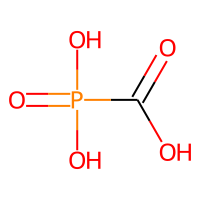
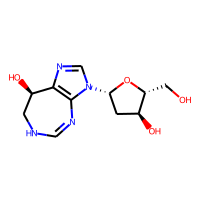
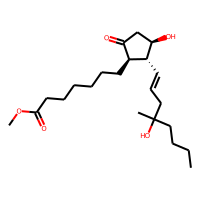

In [27]:
PandasTools.AddMoleculeColumnToFrame(compounds_df, 'smiles', 'molecule', includeFingerprints=True)
compounds_df[:3]

Fingerprint matrix for prediction has shape (2749, 2000)


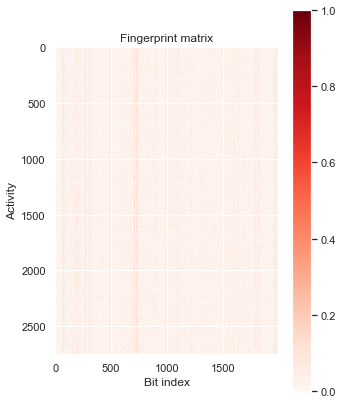

In [28]:
fp_matrix_predict = generate_fp_matrix(compounds_df['molecule'], fp_depth, fp_n_bits)
print(f'Fingerprint matrix for prediction has shape {fp_matrix_predict.shape}')

fig = plt.figure(figsize=(5, 7))
plt.title('Fingerprint matrix')
plt.xlabel('Bit index')
plt.ylabel('Activity')
plt.imshow(fp_matrix_predict, cmap=plt.get_cmap('Reds'))
plt.colorbar()
plt.show()

### Compounds sorted by predicted activity

,molecule_id,name,smiles,is_in_train_set,molecule,p_ic50_predict
930,CHEMBL139367,PERAMIVIR,CCC(CC)[C@H](NC(C)=O)[C@@H]1[C@H](O)[C@@H](C(=...,True,,7.483037
2213,CHEMBL222813,ZANAMIVIR,CC(=O)N[C@@H]1[C@@H](NC(=N)N)C=C(C(=O)O)O[C@H]...,True,,7.478827
1788,CHEMBL2105953,CEFTERAM,CO/N=C(\C(=O)N[C@@H]1C(=O)N2C(C(=O)O)=C(Cn3nnc...,False,,6.514161
1567,CHEMBL1743,CEFDITOREN,CO/N=C(\C(=O)N[C@@H]1C(=O)N2C(C(=O)O)=C(/C=C\c...,False,,6.412876
11,CHEMBL311350,PIROMIDIC ACID,CCn1cc(C(=O)O)c(=O)c2cnc(N3CCCC3)nc21,False,,6.318310
1641,CHEMBL30116,PIPEMIDIC ACID,CCn1cc(C(=O)O)c(=O)c2cnc(N3CCNCC3)nc21,False,,6.310910
235,CHEMBL1572,NETILMICIN,CCN[C@@H]1C[C@H](N)[C@@H](O[C@H]2OC(CN)=CC[C@H...,False,,6.297961
2035,CHEMBL1950576,DIHYDROSTREPTOMYCIN,CN[C@@H]1[C@H](O[C@H]2[C@H](O[C@@H]3[C@@H](NC(...,False,,6.284047
1986,CHEMBL561,LOMEFLOXACIN,CCn1cc(C(=O)O)c(=O)c2cc(F)c(N3CCNC(C)C3)c(F)c21,False,,6.266160
372,CHEMBL3833338,STREPTODUOCIN,CN[C@@H]1[C@H](O[C@H]2[C@H](O[C@@H]3[C@@H](NC(...,False,,6.254641

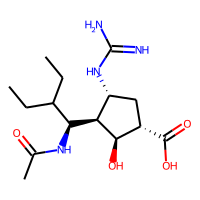
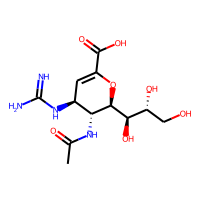
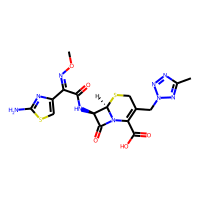
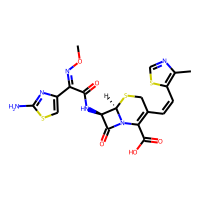
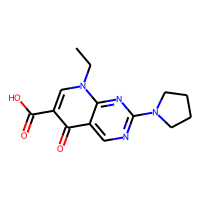
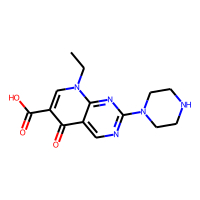
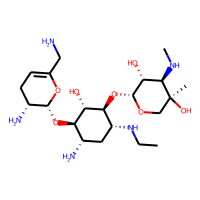
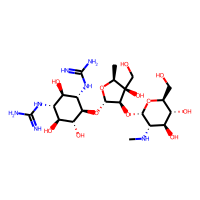
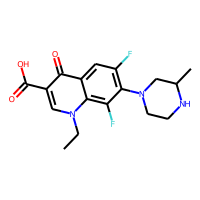
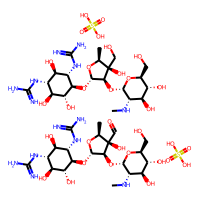

In [29]:
compounds_df['p_ic50_predict'] = rf_reg_all.predict(fp_matrix_predict)
sorted_compounds_df = compounds_df.sort_values('p_ic50_predict', ascending=False)
sorted_compounds_df[:10]

## Hyperparameter influence - fingerprint parameters

In [30]:
fp_depths = [2, 3, 4, 5]
fp_lengths = [64, 128, 256, 512, 1024, 2048, 4096]

def train_and_eval_model(fp_depth, fp_length):
    fp_matrix = generate_fp_matrix(activity_df['molecule'], fp_depth, fp_length)
    X_train, X_test, y_train, y_test = train_test_split(
        fp_matrix, p_ic50_vec, test_size=0.25, random_state=42
    )

    rf_reg = RandomForestRegressor(random_state=0)
    rf_reg.fit(X_train, y_train)

    train_score = rf_reg.score(X_train, y_train)
    test_score = rf_reg.score(X_test, y_test)
    return train_score, test_score

inputs_list = list(itertools.product(fp_depths, fp_lengths))
with ThreadPool() as pool:
    results_list = pool.map(lambda t: train_and_eval_model(t[0], t[1]), inputs_list)
    
train_scores_df = pd.DataFrame(index=fp_depths, columns=fp_lengths, dtype=float)
test_scores_df = train_scores_df.copy()
for (fp_depth, fp_length), (train_score, test_score) in zip(inputs_list, results_list):
    train_scores_df.loc[fp_depth, fp_length] = train_score
    test_scores_df.loc[fp_depth, fp_length] = test_score

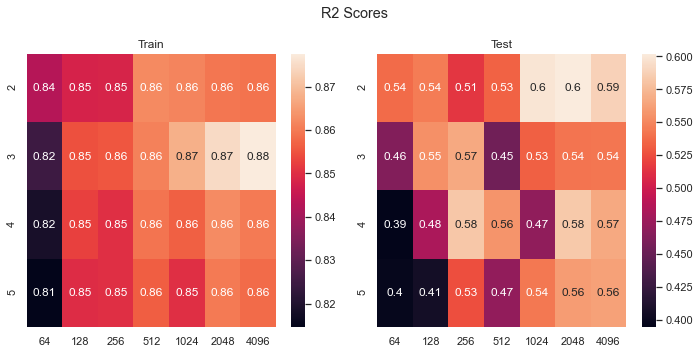

In [31]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('R2 Scores')

for ax in (ax0, ax1):
    ax.set_xlabel('FP length')
    ax.set_ylabel('FP depth')

sns.heatmap(train_scores_df, ax=ax0, annot=True)
ax0.set_title('Train')

sns.heatmap(test_scores_df, ax=ax1, annot=True)
ax1.set_title('Test')

plt.tight_layout()
plt.show()